In [4]:
from src.experiments.common import ExperimentHandler
from src.experiments import sghmc_gradients
import matplotlib.pyplot as plt
import torch
from src.models.mnist import MNISTModel
from src.inference import ParameterPosterior

handler = ExperimentHandler(sghmc_gradients)

# from tensorboard.backend.event_processing import event_accumulator
# acc = event_accumulator.EventAccumulator(str(latest_run.dir / "metrics"))

In [5]:
latest_run = handler.latest_run()
grad_vars = torch.stack(torch.load(latest_run.dir / "gradient_vars.pkl"))

In [6]:
flat_index_pairs = ParameterPosterior(MNISTModel()).flat_index_pairs

In [7]:
inspect_idx = []
with torch.random.fork_rng():
    torch.manual_seed(123)

    for interval in flat_index_pairs:
        inspect_idx.extend(torch.randint(*interval, (2,)))

inspect_idx = torch.tensor(inspect_idx)

Time x Variance billeder, log skala 

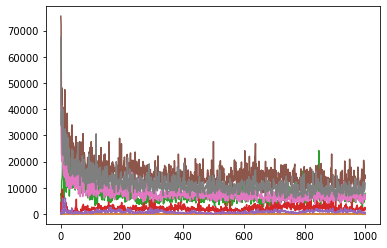

In [8]:
plt.plot(grad_vars[:, inspect_idx])
plt.show()

In [9]:
grads = []
for i in range(1000):
    epoch_grads = torch.load(latest_run.dir/"logged_gradients"/f"gradients_epoch_{i:04}.pt") 
    grads.append(epoch_grads[...,inspect_idx].clone())
    del epoch_grads
grads = torch.stack(grads)

In [10]:
beta = torch.tensor(0.999)
grad_var_estimates = []
grad_var_estimate = torch.zeros((grads.shape[-1],))
for j, x in enumerate(grads.flatten(0, -2)):
    grad_var_estimate = beta * grad_var_estimate + (1-beta) * x**2
    if j % 100 == 1:
        grad_var_estimates.append(grad_var_estimate / (1-torch.pow(beta, j)))

grad_var_estimates = torch.stack(grad_var_estimates)


In [11]:
grads[..., 1]

tensor([[-0.0192, -0.0191, -0.0187,  ...,  0.0263,  0.0268,  0.0273],
        [ 1.7177,  1.7530,  1.7842,  ...,  0.4462,  0.4545,  0.4647],
        [ 0.2712,  0.2659,  0.2600,  ...,  2.5974,  2.5903,  2.5787],
        ...,
        [ 2.3141,  2.3141,  2.3138,  ...,  2.4987,  2.5033,  2.5077],
        [ 2.5079,  2.5119,  2.5164,  ...,  2.8595,  2.8625,  2.8655],
        [ 2.8643,  2.8677,  2.8714,  ...,  3.1624,  3.1667,  3.1710]])

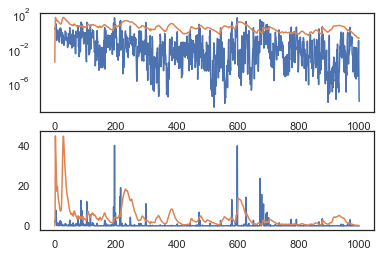

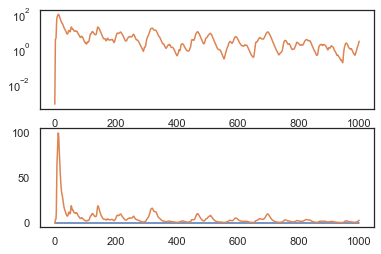

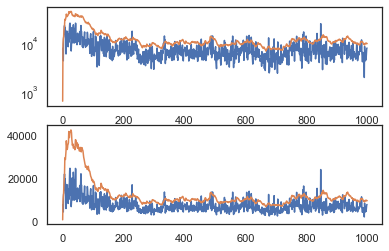

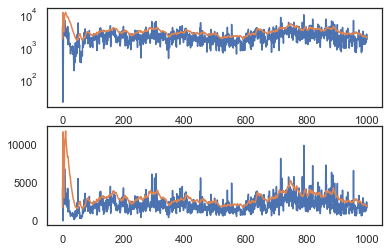

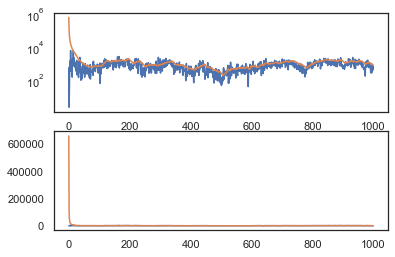

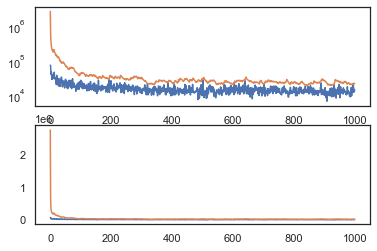

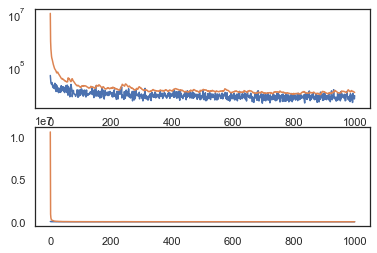

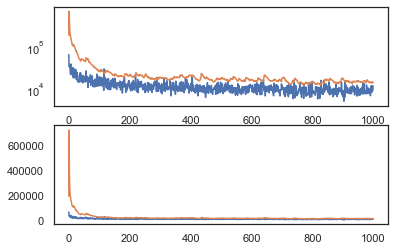

In [71]:
for i, idx in enumerate(inspect_idx):
    fig, axes = plt.subplots(2, 1)
    axes[1].plot(grad_vars[..., idx])
    axes[1].plot(grad_var_estimates[..., i])
    axes[0].plot(grad_vars[..., idx])
    axes[0].plot(grad_var_estimates[..., i])
    axes[0].set_yscale("log")
    plt.show()

In [14]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

In [15]:
dataframes = {}
for i, idx in enumerate(flat_index_pairs):
    # dataframes
    dataframes[i] = pd.DataFrame(grad_vars[::100, slice(*idx)].numpy().T)

In [69]:
df = (
    dataframes[2]
    .melt(var_name="g", value_name="x")
    .assign(x = lambda d: d.x.where( (d.x <= 1e2) & ~(d.x == 0), pd.NA ))
)
df

,g,x
0,0,NaN
1,0,NaN
2,0,NaN
3,0,NaN
4,0,NaN
...,...,...
783995,9,3.296231e-07
783996,9,NaN
783997,9,NaN
783998,9,NaN


In [25]:
df.loc[lambda d: d.x > 20000]

,g,x
14,0,32676.511719
17,0,35007.218750
19,0,27447.896484
20,0,54657.972656
27,0,35456.183594
...,...,...
1967,1,21050.208984
1972,1,20363.773438
1976,1,20167.664062
1983,1,23055.433594


/Users/soren/Repositories/Speciale/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/Users/soren/Repositories/Speciale/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


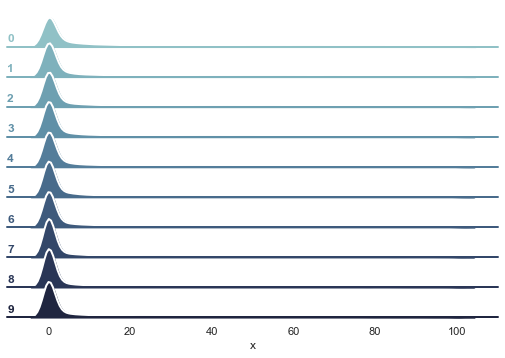

In [70]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)


AttributeError: 'FacetGrid' object has no attribute 'refline'

In [94]:
plt.show()